<a href="https://colab.research.google.com/github/pyannote/pyannote-audio/blob/develop/tutorials/training_a_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Training, fine-tuning, and transfer learning with pyannote.audio

In this tutorial, you will learn how to use pyannote.audio to

- train a voice activity detection model from scratch,
- fine-tune a pretrained speaker segmentation model,
- perform transfer learning (from speaker segmentation to overlapped speech detection)


## Tutorial setup

### `Google Colab` setup

If you are running this tutorial on `Colab`, execute the following commands in order to setup `Colab` environment. These commands will install `pyannote.audio` and download a mini version of the `AMI` corpus.

In [ ]:
!pip install -qq pyannote.audio==3.1.1
!pip install -qq ipython==7.34.0
!git clone https://github.com/pyannote/AMI-diarization-setup.git
%cd ./AMI-diarization-setup/pyannote/
!bash ./download_ami_mini.sh
%cd /content

⚠ Restart the runtime (Runtime > Restart session).

### Non `Google Colab` setup

If you are not using `Colab`, this tutorial assumes that
* `pyannote.audio` has been installed
* the [AMI corpus](https://groups.inf.ed.ac.uk/ami/corpus/) has already been [setup for use with `pyannote`](https://github.com/pyannote/AMI-diarization-setup/tree/main/pyannote)


In [1]:
# preparing notebook for visualization purposes
# (only show outputs between t=180s and t=240s)
from pyannote.core import notebook, Segment
notebook.crop = Segment(210, 240)

## Data preparation

See [`pyannote.database` documentation](https://github.com/pyannote/pyannote-database#pyannote-database) to learn how to prepare your own dataset for training with `pyannote.audio`.

In [ ]:
from pyannote.database import registry, FileFinder

registry.load_database("AMI-diarization-setup/pyannote/database.yml")
ami = registry.get_protocol('AMI.SpeakerDiarization.mini')

## Training a voice activity detection model from scratch

Voice activity detection (VAD) is the task of detecting speech regions in a given audio stream or recording.

We initialize a VAD *task* that describes how the model will be trained:

* `ami` indicates that we will use files available in `ami.train()`.
* `duration=2.` and `batch_size=128` indicates that the model will ingest batches of 128 two seconds long audio chunks.

In [ ]:
from pyannote.audio.tasks import VoiceActivityDetection
vad_task = VoiceActivityDetection(ami, duration=2.0, batch_size=128)

We initialize one *model* with the `PyanNet` architecture used [in that paper](https://arxiv.org/abs/2104.04045).  
In particular, we increase the default stride of the initial `sincnet` feature extraction layer to `10`.

The model is also provided with the task (`task=vad_task`) for which it is being trained:

In [4]:
from pyannote.audio.models.segmentation import PyanNet
vad_model = PyanNet(task=vad_task, sincnet={'stride': 10})

Now that everything is ready, let's train with `pytorch-ligthning`!

In [5]:
import pytorch_lightning as pl

trainer = pl.Trainer(devices=1, max_epochs=1)
trainer.fit(vad_model)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name              | Type             | Params | In sizes      | Out sizes                                  
---------------------------------------------------------------------------------------------------------------------
0 | sincnet           | SincNet          | 42.6 K | [1, 1, 32000] | [1, 60, 115]                               
1 | lstm              | LSTM             | 589 K  | [1, 115, 60]  | [[1, 115, 256], [[4, 1, 128], [4, 1, 128]]]
2 | linear            | ModuleList       | 49.4 K | ?             | ?                                          
3 | classifier        | Linear           | 129    | [1, 115, 128] | [1, 115, 1]                                
4 | activation        | Sigmoid          | 0      | [1, 115, 1]   | [1, 115, 1]                                
5 | validation_metric | MetricCollection | 0      | ?         

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


For the purpose of this tutorial, the model is trained for only 1 epoch. One can obviously expect better performance by training longer and on more data.

See [`pytorch-lightning`](https://www.pytorchlightning.ai/) documentation to learn more about the [`Trainer` API](https://pytorch-lightning.readthedocs.io/en/latest/common/trainer.html), in particular.

Once trained, the model can be applied to a test file:

In [6]:
test_file = next(ami.test())
# here we use a test file provided by the protocol, but it could be any audio file
# e.g. test_file = "/path/to/test.wav".

Because the model was trained on 2s audio chunks and that test files are likely to be much longer than that, we wrap the `model` with an `Inference` instance: it will take care of sliding a 2s window over the whole file and aggregate the output of the model.

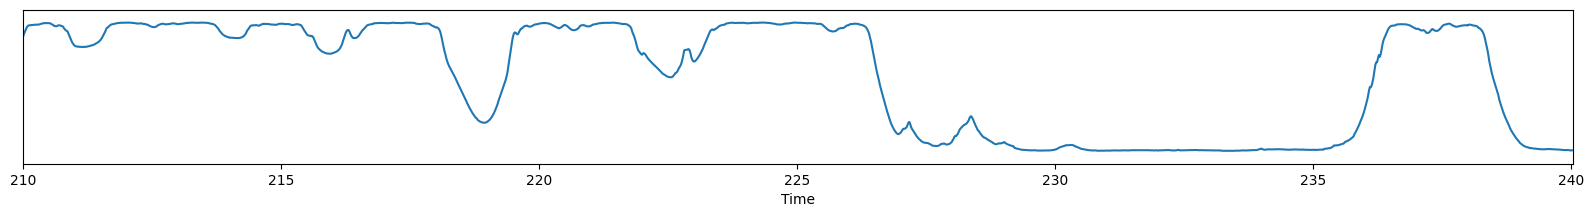

In [7]:
from pyannote.audio import Inference
vad = Inference(vad_model)

vad_probability = vad(test_file)
vad_probability

Perfect voice activity detection output should look like that:

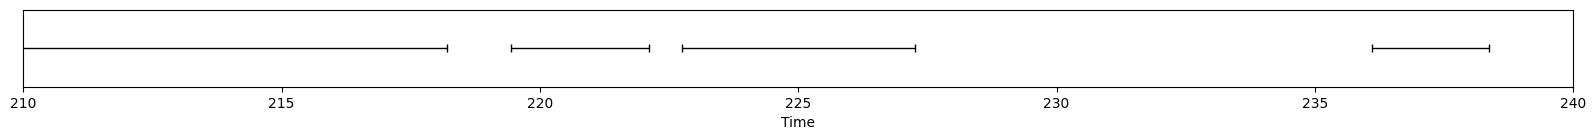

In [8]:
expected_output = test_file["annotation"].get_timeline().support()
expected_output

## Fine-tuning a pretrained speaker segmentation model

Speaker diarization is the task of partitioning a given audio stream of recording into according to the speaker identity.

[`pyannote/segmentation`](https://huggingface.co/pyannote/segmentation-3.0) is a model that was pretrained to perform speaker diarization, but only locally, on 10s-long audio chunks.

To load the speaker segmentation model,

* accept the user conditions on [hf.co/pyannote/segmentation](https://hf.co/pyannote/segmentation-3.0).
* login using `notebook_login` below

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [10]:
from pyannote.audio import Model
pretrained = Model.from_pretrained("pyannote/segmentation-3.0", use_auth_token=True)

Let's visualize how it performs on our test file:

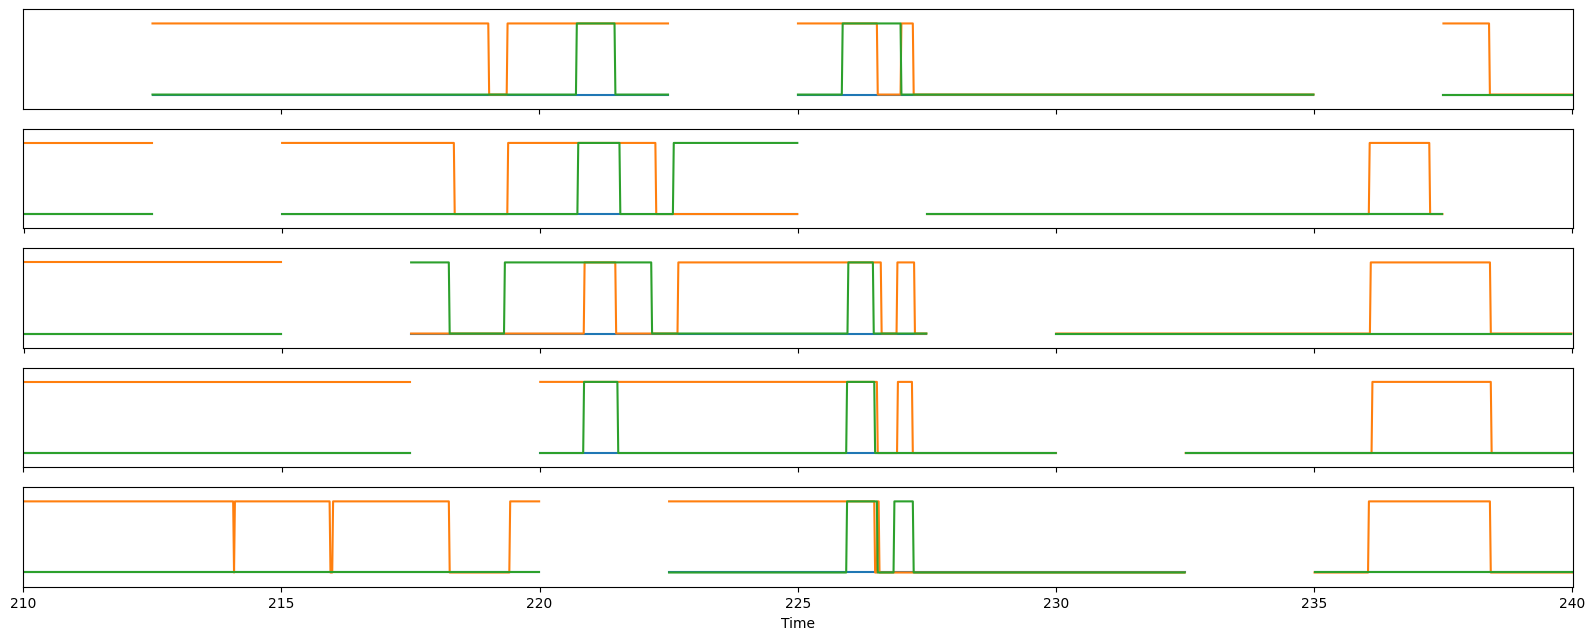

In [11]:
spk_probability = Inference(pretrained, step=2.5)(test_file)
spk_probability

A perfect output would look like that:

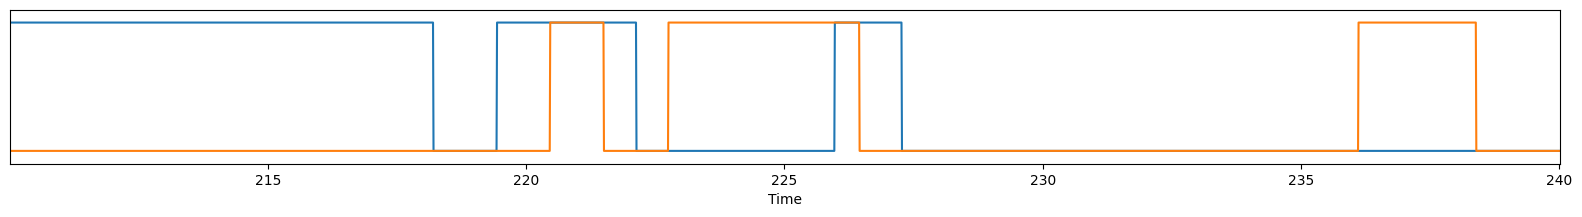

In [12]:
test_file["annotation"].discretize(notebook.crop, resolution=0.010)

We are going to fine-tune this pretrained model on the AMI dataset:

In [13]:
from pyannote.audio.tasks import SpeakerDiarization
seg_task = SpeakerDiarization(ami, duration=10.0, max_speakers_per_chunk=3, max_speakers_per_frame=2)

To check that fine-tuning was actually helpful, we need to evaluate the performance of the pretrained model, and compute the average local diarization error rate on a 10s window sliding over the whole test set. To do so, we need to create a helper function:

In [14]:
def test(model, protocol, subset="test"):
    from pyannote.audio.utils.signal import binarize
    from pyannote.audio.utils.metric import DiscreteDiarizationErrorRate
    from pyannote.audio.pipelines.utils import get_devices

    (device,) = get_devices(needs=1)
    metric = DiscreteDiarizationErrorRate()
    files = list(getattr(protocol, subset)())

    inference = Inference(model, device=device)

    for file in files:
        reference = file["annotation"]
        hypothesis = binarize(inference(file))
        uem = file["annotated"]
        _ = metric(reference, hypothesis, uem=uem)

    return abs(metric)

We can then evaluate the model and see its local DER:

In [15]:
der_pretrained = test(model=pretrained, protocol=ami, subset="test")
print(f"Local DER (pretrained) = {der_pretrained * 100:.1f}%")

Local DER (pretrained) = 19.7%


Next, we prepare the model for fine-tuning, simply by overriding its `task` attribute...

In [16]:
from copy import deepcopy
finetuned = deepcopy(pretrained)
finetuned.task = seg_task

... and we train it (for just one epoch)

In [17]:
trainer = pl.Trainer(devices=1, max_epochs=1)
trainer.fit(finetuned)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



  | Name              | Type             | Params | In sizes       | Out sizes                                  
----------------------------------------------------------------------------------------------------------------------
0 | sincnet           | SincNet          | 42.6 K | [1, 1, 160000] | [1, 60, 589]                               
1 | lstm              | LSTM             | 1.4 M  | [1, 589, 60]   | [[1, 589, 256], [[8, 1, 128], [8, 1, 128]]]
2 | linear            | ModuleList       | 49.4 K | ?              | ?                                          
3 | classifier        | Linear           | 903    | [1, 589, 128]  | [1, 589, 7]                                
4 | activation        | LogSoftmax       | 0      | [1, 589, 7]    | [1, 589, 7]                                
5 | powerset          | Powerset         | 0      | ?              | ?                                          
6 | validation_metric | MetricCollection | 0      | ?              | ?                   

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


We now evaluate the performance of the fine-tuned model...

In [18]:
der_finetuned = test(model=finetuned, protocol=ami, subset="test")
print(f"Local DER (finetuned) = {der_finetuned * 100:.1f}%")

Local DER (finetuned) = 18.8%


... to confirm that it actually improved its performance on the AMI test set.


## Transfer learning

What if you are only interested in detecting overlapped speech regions?

Looking at the output of the `pyannote/segmentation-3.0` model, it seems that it would be a good starting point for training such a dedicated model:

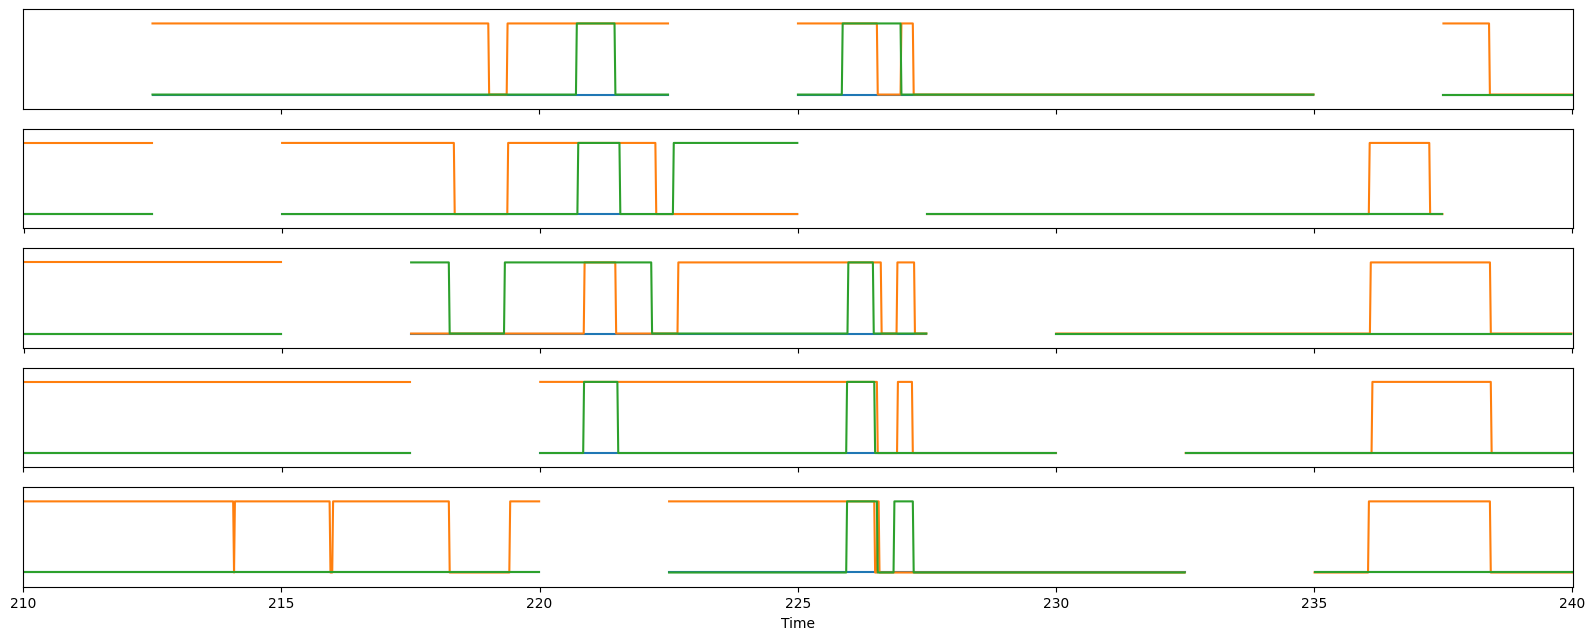

In [19]:
Inference('pyannote/segmentation-3.0', use_auth_token=True, step=2.5)(test_file)

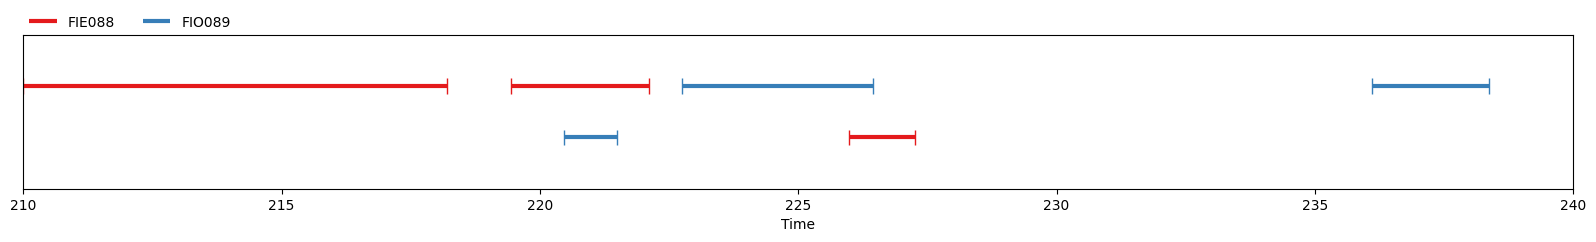

In [20]:
test_file["annotation"]

Let's update the model so that it specifically addresses overlapped speech detection.  
This is achieved very simply by updating the `task` attribute...

In [21]:
from pyannote.audio.tasks import OverlappedSpeechDetection
osd_task = OverlappedSpeechDetection(ami, duration=2.0)

osd_model = Model.from_pretrained("pyannote/segmentation-3.0", use_auth_token=True)
osd_model.task = osd_task

... optionally freeezing a bunch of layers...

In [22]:
osd_model.freeze_up_to('lstm')

['sincnet',
 'sincnet.wav_norm1d',
 'sincnet.conv1d',
 'sincnet.conv1d.0',
 'sincnet.conv1d.0.filterbank',
 'sincnet.conv1d.1',
 'sincnet.conv1d.2',
 'sincnet.pool1d',
 'sincnet.pool1d.0',
 'sincnet.pool1d.1',
 'sincnet.pool1d.2',
 'sincnet.norm1d',
 'sincnet.norm1d.0',
 'sincnet.norm1d.1',
 'sincnet.norm1d.2',
 'lstm']

... and training it:

In [23]:
trainer = pl.Trainer(devices=1, max_epochs=1)
trainer.fit(osd_model)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



  | Name              | Type             | Params | In sizes      | Out sizes                                  
---------------------------------------------------------------------------------------------------------------------
0 | sincnet           | SincNet          | 42.6 K | [1, 1, 32000] | [1, 60, 115]                               
1 | lstm              | LSTM             | 1.4 M  | [1, 115, 60]  | [[1, 115, 256], [[8, 1, 128], [8, 1, 128]]]
2 | linear            | ModuleList       | 49.4 K | ?             | ?                                          
3 | classifier        | Linear           | 129    | [1, 115, 128] | [1, 115, 1]                                
4 | activation        | Sigmoid          | 0      | [1, 115, 1]   | [1, 115, 1]                                
5 | validation_metric | MetricCollection | 0      | ?             | ?                                          
-------------------------------------------------------------------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


Et voilà! A brand new overlapped speech detection model!

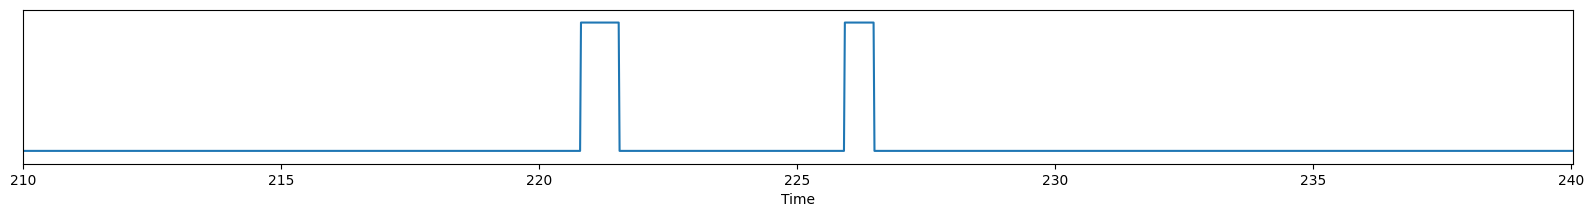

In [24]:
from pyannote.audio.utils.signal import binarize
binarize(Inference(osd_model)(test_file))

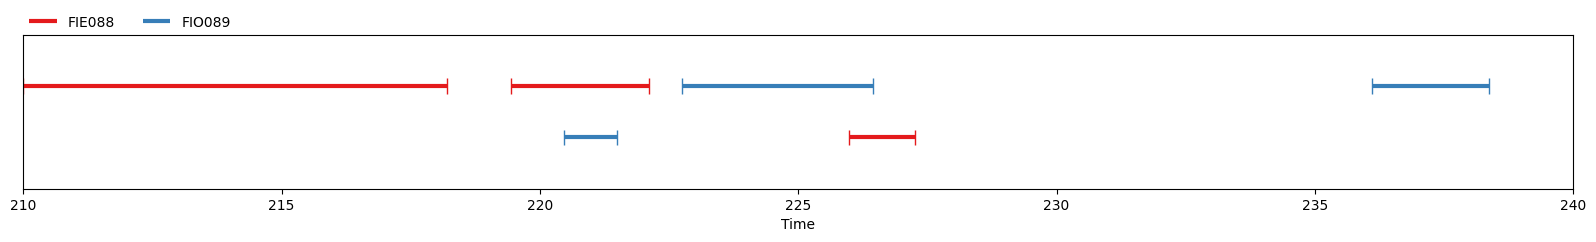

In [25]:
test_file["annotation"]

## Going further

This tutorial only scratched the surface of the training API.

Every task supports an `augmentation` parameter for training with data augmentation via [`torch-audiomentations`](https://github.com/asteroid-team/torch-audiomentations) library:

```python
from torch_audiomentations import AddBackgroundNoise
augmentation = AddBackgroundNoise("/path/to/background/noise/directory")
vad_task = VoiceActivityDetection(ami, augmentation=augmentation)
```

We also benefit from all the nice things [`pytorch-lightning`](https://lightning.ai/docs/pytorch/stable/) has to offer (like multi-gpu training, for instance).

```python
trainer = Trainer(devices=4, accelerator="gpu", strategy='ddp')
trainer.fit(model)
```

Default optimizer (`Adam` with default parameters) is automatically set up for you.  
Customizing optimizer (and scheduler) requires overriding [`model.configure_optimizers`](https://lightning.ai/docs/pytorch/stable/common/lightning_module.html#configure-optimizers) method:

```python
from types import MethodType
from torch.optim import SGD
from torch.optim.lr_scheduler import ExponentialLR
def configure_optimizers(self):
    return {"optimizer": SGD(self.parameters()),
            "lr_scheduler": ExponentialLR(optimizer, 0.9)}
model.configure_optimizers = MethodType(configure_optimizers, model)
trainer.fit(model)
```